# 📚 Proyecto de Análisis de Sentimientos usando Lenguaje Natural

## 🎯 Problema de Negocio

El objetivo de este proyecto es analizar los sentimientos de los comentarios, identificando si los mensajes son positivos o negativos.

## ❓ Preguntas Clave

- 📈 **¿Qué tan efectivos son los análisis de sentimientos aplicados sobre datos textuales?**
- 🔄 **¿Qué transformaciones y características textuales son relevantes para mejorar la predicción de sentimientos?**
- 😏 **¿Cómo podemos detectar sarcasmo en textos utilizando técnicas de análisis de sentimientos?**
- 🧮 **¿Qué métricas se pueden utilizar para evaluar el desempeño del modelo?**


## 1. 🚀 Configuración del Ambiente

Asegúrate de tener instaladas las siguientes bibliotecas necesarias para la ejecución del código:

```bash
pip install pandas numpy seaborn matplotlib scikit-learn nltk unidecode
```

In [3]:
%%capture
!pip install pandas numpy seaborn matplotlib scikit-learn nltk unidecode
!pip install nltk
!pip install emoji
!pip install vaderSentiment
!pip install textblob
!pip install num2words
!pip install transformers

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import string
import sklearn
import emoji
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
import math
from num2words import num2words

import textblob
from textblob import TextBlob
import nltk
nltk.download('stopwords')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## 2. CARGA DE BASE DE DATOS

In [5]:
df = pd.read_csv('comentarios_productos.csv')
df.head(10)

,comentario,nota,sentimiento
0,No doubt it has a great bass and to a great ex...,3,neutro
1,"This earphones are unreliable, i bought it be...",1,negativo
2,"i bought itfor 999,I purchased it second time,...",4,positivo
3,Its sound quality is adorable. overall it was ...,1,negativo
4,Its Awesome... Good sound quality & 8-9 hrs ba...,5,positivo
5,"After 11 days, the charging port isn't working...",1,negativo
6,Sound-4.5/5Build quality-4.5/5Battery life -4/...,4,positivo
7,After one month usage reviewing this .Pros-1- ...,3,neutro
8,I can’t get enough of this earphone! The bass ...,5,positivo
9,The product durability is 1 month..I just lost...,1,negativo


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14337 entries, 0 to 14336
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   comentario   14337 non-null  object
 1   nota         14337 non-null  int64 
 2   sentimiento  14337 non-null  object
dtypes: int64(1), object(2)
memory usage: 336.2+ KB


* Observamos que no hay presencia de valores nulos.

In [7]:
## Verificando los tipos de categorias en nuestra variable onjetivo 'sentimiento'
df.value_counts('sentimiento')

,count
sentimiento,
positivo,9402
negativo,3432
neutro,1503


* Notamos que tenemos menos datos para el sentimiento Neutro, consideramos la opción de convertirlo en uno de los otros dos sentimientos, con la finalidad de tener una predicción binaria.

* Observamos que los comentarios tienen nota, que van del 1 al 5, donde:
  * 3 : Neutro
  * 1,2 : Negativo
  * 4,5 : Positivo

* Al tener menos comentarios neutros, decidimos convertirlos a Negativo, y de esta manera balancear mejor nuestro dataset. Los comentarios al ser Neutros, para nosotros se comportarán como negativos, ya que no aportan sentimiento al texto.

In [8]:
## convertir neutro de sentimientos a negativo
df['sentimiento'] = df['sentimiento'].apply(lambda x: 'negativo' if x == 'neutro' else x)

In [9]:
df.value_counts('sentimiento')

,count
sentimiento,
positivo,9402
negativo,4935


* Ahora tenemos solo sentimientos positivos y negativos.
* Existe mucha más cantidad de comentarios positivos que negativos, lo cual resultará en el desafío del proyecto, porque obtener métricas altas, por más que existe desbalance.
* Decidimos no atacar el desbalance, debido a que estamos trabajando con comentarios de palabras, las cuales pueden ser dificiles de recrear sin incluir algo de sesgo en el modelo.


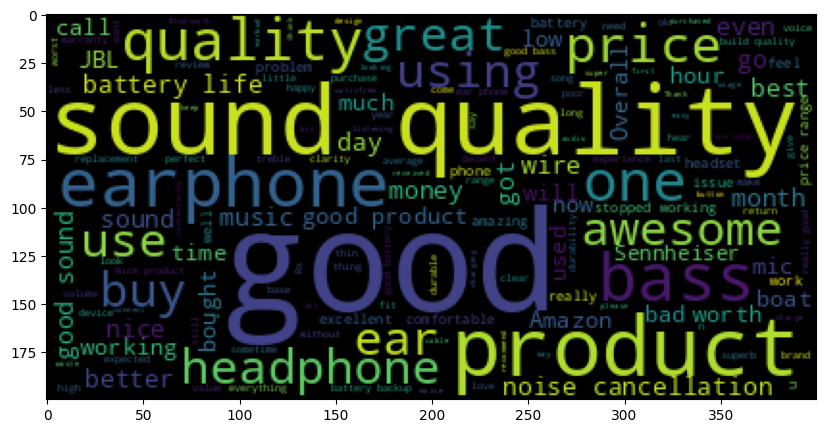

In [10]:
## Visualizando las palabras más frecuentes en las evaluaciones

todas_las_palabras = ' '.join([texto for texto in df.comentario])

### Generar la nube de palabras
from wordcloud import WordCloud
nube_de_palabras = WordCloud().generate(todas_las_palabras)
plt.figure(figsize=(12,5))
plt.imshow(nube_de_palabras)
plt.show()

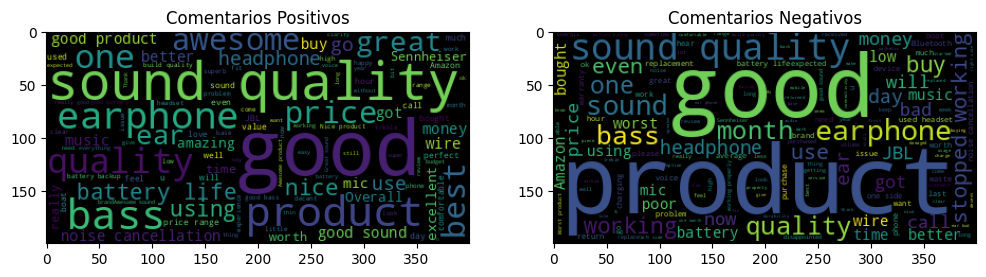

In [11]:
palabras_negativas = ' '.join([texto for texto in df[df['sentimiento'] == 'negativo'].comentario])
palabras_positivas = ' '.join([texto for texto in df[df['sentimiento'] == 'positivo'].comentario])

nube_de_palabras_positivas = WordCloud().generate(palabras_positivas)
nube_de_palabras_negativas = WordCloud().generate(palabras_negativas)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(nube_de_palabras_positivas)
plt.title('Comentarios Positivos')
plt.subplot(1,2,2)
plt.imshow(nube_de_palabras_negativas)
plt.title('Comentarios Negativos')
plt.show()

## 3 TRATAMIENTO DE DATOS

* En este apartado, trataremos de mejorar nuestros comentarios, con la finalidad de poder tener un texto más limpio y ordenado que nuestro modelo pueda entender.
* Se abordará el tratamiento de hashtags, URLs, signos de puntuación, emoticones, número a texto, apóstrofes, mayúsculas, entre otros.

### 3.1 PRIMER TRATAMIENTO

In [12]:
## Definimos nuestra primera función de limpieza de texto

def clean_text(text):
    ## Eliminar URLs (http, https, www)
    text = re.sub(r'http\S+|www\S+', '', text)

    ## Eliminar menciones de usuarios
    text = re.sub(r'@[^\s]+', '', text)

    ## Eliminando los Hashtags
    text = re.sub(r'#\w+', '', text)

    ## Eliminando los emojis
    text = emoji.replace_emoji(text, replace="")

    ## Eliminar dominios .com (palabras terminadas en .com)
    text = re.sub(r'\b\S*\.com\b', '', text)

    # Eliminar caracteres no ASCII (como â\x99«)
    text = re.sub(r'[^\x00-\x7F]+', '', text)

    ## Convirtiendo % en palabra percent
    text = re.sub(r'%', ' percent', text)

    ## Eliminando los apóstrofes
    text = re.sub(r"\'s", '', text)

    ## Eliminando signos de puntuación
    # text = text.translate(str.maketrans('', '', string.punctuation + '¡¿'))
    text = re.sub(rf"[{re.escape(string.punctuation)}]", ' ', text)

    ## Cambiando los múltiples espacios en blanco a espacio simple
    # text = text.replace('  ', ' ')
    text = re.sub(r'\s+', ' ', text)

    ## Cambiando los números por textos
    text = re.sub(r'\d+', lambda m: num2words(int(m.group())), text)

    ## Eliminando espacios al inicio y final
    text = text.strip()

    ## Convirtiendo a Minúsculas
    text = text.lower()

    return text

In [13]:
df['tratamiento_1'] = df['comentario'].apply(clean_text)
df

,comentario,nota,sentimiento,tratamiento_1
0,No doubt it has a great bass and to a great ex...,3,negativo,no doubt it has a great bass and to a great ex...
1,"This earphones are unreliable, i bought it be...",1,negativo,this earphones are unreliable i bought it befo...
2,"i bought itfor 999,I purchased it second time,...",4,positivo,i bought itfor nine hundred and ninety-nine i ...
3,Its sound quality is adorable. overall it was ...,1,negativo,its sound quality is adorable overall it was g...
4,Its Awesome... Good sound quality & 8-9 hrs ba...,5,positivo,its awesome good sound quality eight nine hrs ...
...,...,...,...,...
14332,Good,4,positivo,good
14333,An amazing product but a bit costly.,5,positivo,an amazing product but a bit costly
14334,Sound,1,negativo,sound
14335,the sound is good battery life is good but the...,5,positivo,the sound is good battery life is good but the...


### VECTORIZANDO CON COUNTVECTORIZER

In [14]:
## Vextorizando las palabras
vectorizador = CountVectorizer(lowercase=False, max_features=100)

In [15]:
## Consiguiendo bolsa de palabras de todo la columna tratamiento_1
bolsa_de_palabras = vectorizador.fit_transform(df.tratamiento_1)
print(bolsa_de_palabras.shape)

(14337, 100)


In [16]:
## Crear una matriz dispersa de las evaluaciones
matriz_dispersa_evaluaciones = pd.DataFrame.sparse.from_spmatrix(bolsa_de_palabras, columns=vectorizador.get_feature_names_out())
matriz_dispersa_evaluaciones

,after,all,also,am,amazing,amazon,and,are,as,at,...,very,was,when,which,while,will,with,working,worth,you
0,0,0,0,0,0,0,4,1,0,0,...,1,0,0,1,0,0,0,0,0,0
1,0,0,2,0,0,0,3,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,3,0,0,1,...,0,0,1,0,0,0,0,0,0,1
3,1,0,0,1,0,0,2,0,0,0,...,0,1,0,0,0,0,0,1,0,0
4,0,0,0,0,0,2,1,0,0,0,...,2,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14332,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14333,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14334,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14335,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


### ENTRENANDO EL MODELO

In [17]:
## Clasificación de los sentimientos

### Dividiendo el conjunto de datos en conjuntos de entrenamiento y prueba
from sklearn.model_selection import train_test_split

X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(matriz_dispersa_evaluaciones, df.sentimiento, random_state=4978)

### Creando y entrenando el modelo de regresión logística
from sklearn.linear_model import LogisticRegression
regresion_logistica_1 = LogisticRegression()
regresion_logistica_1.fit(X_entrenamiento, y_entrenamiento)
exactitud_1 = regresion_logistica_1.score(X_prueba, y_prueba)
print(exactitud_1)

0.800278940027894


In [18]:
# nube_de_palabras.words_

In [19]:
# nltk.corpus.stopwords.words('english')

### 3.2 SEGUNDO TRATAMIENTO

In [20]:
## En esta parte trataremos nuestro texto de tratamiento_1 excluyendo las stopwords
df['tratamiento_2'] = df['tratamiento_1'].apply(lambda x: ' '.join([word for word in x.split() if word not in (nltk.corpus.stopwords.words('english'))]))
df

,comentario,nota,sentimiento,tratamiento_1,tratamiento_2
0,No doubt it has a great bass and to a great ex...,3,negativo,no doubt it has a great bass and to a great ex...,doubt great bass great extent noise cancellati...
1,"This earphones are unreliable, i bought it be...",1,negativo,this earphones are unreliable i bought it befo...,earphones unreliable bought fifteen days meanw...
2,"i bought itfor 999,I purchased it second time,...",4,positivo,i bought itfor nine hundred and ninety-nine i ...,bought itfor nine hundred ninety-nine purchase...
3,Its sound quality is adorable. overall it was ...,1,negativo,its sound quality is adorable overall it was g...,sound quality adorable overall good two weeks ...
4,Its Awesome... Good sound quality & 8-9 hrs ba...,5,positivo,its awesome good sound quality eight nine hrs ...,awesome good sound quality eight nine hrs batt...
...,...,...,...,...,...
14332,Good,4,positivo,good,good
14333,An amazing product but a bit costly.,5,positivo,an amazing product but a bit costly,amazing product bit costly
14334,Sound,1,negativo,sound,sound
14335,the sound is good battery life is good but the...,5,positivo,the sound is good battery life is good but the...,sound good battery life good wire long good pr...


### VECTORIZANDO CON COUNTVECTORIZER

In [21]:
bolsa_de_palabras_2 = vectorizador.fit_transform(df.tratamiento_2)
matriz_dispersa_evaluaciones_2 = pd.DataFrame.sparse.from_spmatrix(bolsa_de_palabras_2, columns=vectorizador.get_feature_names_out())

### ENTRENANDO EL MODELO

In [22]:
### Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
from sklearn.model_selection import train_test_split

X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(matriz_dispersa_evaluaciones_2, df.sentimiento, random_state=4978)

### Crear y entrenar el modelo de regresión logística
from sklearn.linear_model import LogisticRegression
regresion_logistica_2 = LogisticRegression()
regresion_logistica_2.fit(X_entrenamiento, y_entrenamiento)
exactitud_2 = regresion_logistica_2.score(X_prueba, y_prueba)
print(exactitud_2)

0.799163179916318


### 3.3 TERCER TRATAMIENTO

El stemming es un proceso de procesamiento de texto que consiste en reducir las palabras a su raíz o raíz común (stem). Esta raíz no necesariamente es una palabra con significado, pero busca ser una forma base que facilite la comparación entre palabras relacionadas.

In [23]:
## Buscamos reducir a su forma base las palabras
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
df['tratamiento_3'] = df['tratamiento_2'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))
df

,comentario,nota,sentimiento,tratamiento_1,tratamiento_2,tratamiento_3
0,No doubt it has a great bass and to a great ex...,3,negativo,no doubt it has a great bass and to a great ex...,doubt great bass great extent noise cancellati...,doubt great bass great extent nois cancel dece...
1,"This earphones are unreliable, i bought it be...",1,negativo,this earphones are unreliable i bought it befo...,earphones unreliable bought fifteen days meanw...,earphon unreli bought fifteen day meanwhil rig...
2,"i bought itfor 999,I purchased it second time,...",4,positivo,i bought itfor nine hundred and ninety-nine i ...,bought itfor nine hundred ninety-nine purchase...,bought itfor nine hundr ninety-nin purchas sec...
3,Its sound quality is adorable. overall it was ...,1,negativo,its sound quality is adorable overall it was g...,sound quality adorable overall good two weeks ...,sound qualiti ador overal good two week stop w...
4,Its Awesome... Good sound quality & 8-9 hrs ba...,5,positivo,its awesome good sound quality eight nine hrs ...,awesome good sound quality eight nine hrs batt...,awesom good sound qualiti eight nine hr batter...
...,...,...,...,...,...,...
14332,Good,4,positivo,good,good,good
14333,An amazing product but a bit costly.,5,positivo,an amazing product but a bit costly,amazing product bit costly,amaz product bit costli
14334,Sound,1,negativo,sound,sound,sound
14335,the sound is good battery life is good but the...,5,positivo,the sound is good battery life is good but the...,sound good battery life good wire long good pr...,sound good batteri life good wire long good pr...


### VECTORIZANDO COUNT-VECTORIZER

In [24]:
bolsa_de_palabras_3 = vectorizador.fit_transform(df.tratamiento_3)
matriz_dispersa_evaluaciones_3 = pd.DataFrame.sparse.from_spmatrix(bolsa_de_palabras_3, columns=vectorizador.get_feature_names_out())

### ENTRENANDO EL MODELO

In [25]:
### Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
from sklearn.model_selection import train_test_split

X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(matriz_dispersa_evaluaciones_3, df.sentimiento, random_state=4978)

### Crear y entrenar el modelo de regresión logística
from sklearn.linear_model import LogisticRegression
regresion_logistica_3 = LogisticRegression()
regresion_logistica_3.fit(X_entrenamiento, y_entrenamiento)
exactitud_3 = regresion_logistica_3.score(X_prueba, y_prueba)
print(exactitud_3)

0.804463040446304


### 3.4 CUARTO TRATAMIENTO

Lemmatización: Reduce palabras a su forma base utilizando un análisis lingüístico más completo.

> Stemming o Lematización: Decide cuál usar dependiendo del contexto:
  * Stemming (PorterStemmer o SnowballStemmer): Si necesitas rapidez y no te importa sacrificar precisión.
  * Lematización: Si necesitas obtener palabras reales y tu análisis requiere mayor precisión (recomendado para análisis de sentimientos en español).

In [26]:
# Download the Spanish language model
%%capture
!python -m spacy download es_core_news_sm

In [27]:
import spacy
nlp = spacy.load("es_core_news_sm")

# Aplicando lematización
df['tratamiento_4'] = df['tratamiento_2'].apply(lambda x: ' '.join([token.lemma_ for token in nlp(x)]))
df

,comentario,nota,sentimiento,tratamiento_1,tratamiento_2,tratamiento_3,tratamiento_4
0,No doubt it has a great bass and to a great ex...,3,negativo,no doubt it has a great bass and to a great ex...,doubt great bass great extent noise cancellati...,doubt great bass great extent nois cancel dece...,doubt great bass great extent noise cancellati...
1,"This earphones are unreliable, i bought it be...",1,negativo,this earphones are unreliable i bought it befo...,earphones unreliable bought fifteen days meanw...,earphon unreli bought fifteen day meanwhil rig...,earphón unreliable bought fifteir days meanwhi...
2,"i bought itfor 999,I purchased it second time,...",4,positivo,i bought itfor nine hundred and ninety-nine i ...,bought itfor nine hundred ninety-nine purchase...,bought itfor nine hundr ninety-nin purchas sec...,bought itfor nine hundred ninety-nine purchase...
3,Its sound quality is adorable. overall it was ...,1,negativo,its sound quality is adorable overall it was g...,sound quality adorable overall good two weeks ...,sound qualiti ador overal good two week stop w...,sound quality adorable overall good two weeks ...
4,Its Awesome... Good sound quality & 8-9 hrs ba...,5,positivo,its awesome good sound quality eight nine hrs ...,awesome good sound quality eight nine hrs batt...,awesom good sound qualiti eight nine hr batter...,awesome good sound quality eight nine hrs batt...
...,...,...,...,...,...,...,...
14332,Good,4,positivo,good,good,good,good
14333,An amazing product but a bit costly.,5,positivo,an amazing product but a bit costly,amazing product bit costly,amaz product bit costli,amazing product bit costly
14334,Sound,1,negativo,sound,sound,sound,sound
14335,the sound is good battery life is good but the...,5,positivo,the sound is good battery life is good but the...,sound good battery life good wire long good pr...,sound good batteri life good wire long good pr...,sound good battery life good wire long good pr...


### VECTORIZANDO COUNT-VECTORIZER

In [28]:
bolsa_de_palabras_4 = vectorizador.fit_transform(df.tratamiento_4)
matriz_dispersa_evaluaciones_4 = pd.DataFrame.sparse.from_spmatrix(bolsa_de_palabras_4, columns=vectorizador.get_feature_names_out())

### ENTRENANDO EL MODELO

In [29]:
### Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
from sklearn.model_selection import train_test_split

X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(matriz_dispersa_evaluaciones_4, df.sentimiento, random_state=4978)

### Crear y entrenar el modelo de regresión logística
from sklearn.linear_model import LogisticRegression
regresion_logistica_4 = LogisticRegression()
regresion_logistica_4.fit(X_entrenamiento, y_entrenamiento)
exactitud_4 = regresion_logistica_4.score(X_prueba, y_prueba)
print(exactitud_4)

0.7930264993026499


* Observamos que en este caso, funciona mejor, el Steeming que la Lematización, en términos de accuracy.
* Decidimos quedarnos con el tratamiento_3

## 3. 📐 FEATURE ENGINEERING

* En este apartado, nos enfocaremos en generar otras características que pueden ser relevante para nuestro análisis de sentimiento, como puede ser el conteo de palabras total, conte de palabras únicas, polaridad (sentimiento general del texto), subjetividad (cuanto de opinión o hecho tiene un texto), palabras negativas, palabras neutras y palabras positivas en el texto, emociones del texto, entre otras.

### 3.1 Conteo de Palabras

In [30]:
## Feature Engineering
matriz_dispersa_evaluaciones_new = matriz_dispersa_evaluaciones_3.copy()
matriz_dispersa_evaluaciones_new['num_palabras'] = df['tratamiento_3'].apply(lambda x: len(x.split()))
matriz_dispersa_evaluaciones_new

,also,amaz,amazon,awesom,backup,bad,bass,batteri,best,better,...,volum,warranti,well,wire,work,worst,worth,would,year,num_palabras
0,0,0,0,0,0,0,1,1,0,0,...,0,0,0,1,0,1,0,0,0,49
1,2,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,40
2,0,0,0,2,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,54
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,16
4,0,0,2,1,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14332,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
14333,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
14334,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
14335,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,9


### 3.2 Conteo de Palabras únicas

In [31]:
## Palabras únicas en el texto
matriz_dispersa_evaluaciones_new['num_palabras_unicas'] = df['tratamiento_3'].apply(lambda x: len(set(x.split())))
matriz_dispersa_evaluaciones_new

,also,amaz,amazon,awesom,backup,bad,bass,batteri,best,better,...,warranti,well,wire,work,worst,worth,would,year,num_palabras,num_palabras_unicas
0,0,0,0,0,0,0,1,1,0,0,...,0,0,1,0,1,0,0,0,49,48
1,2,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,40,35
2,0,0,0,2,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,54,42
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,16,16
4,0,0,2,1,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,28,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14332,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
14333,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,4
14334,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
14335,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,9,7


In [32]:
matriz_dispersa_evaluaciones_new['num_palabras'].min(), matriz_dispersa_evaluaciones_new['num_palabras'].max()

(0, 508)

* Notamos algo curioso, tenemos como mínimo de número de palabras cero, lo cuál significa que tenemos texto vacío.
* El mínimo debería ser uno.


In [33]:
## Evaluamos nuestras filas que tienen números de palabras = 0
matriz_dispersa_evaluaciones_new[matriz_dispersa_evaluaciones_new['num_palabras'] == 0]

,also,amaz,amazon,awesom,backup,bad,bass,batteri,best,better,...,warranti,well,wire,work,worst,worth,would,year,num_palabras,num_palabras_unicas
3106,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3175,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3546,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3675,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3726,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4605,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5159,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5742,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6211,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6662,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


* Observamos que son 17 filas las cuales en este momento tienen valores nulos, los cuales no podemos llevar al modelo.

### VALIDANDO PORQUE EXISTEN LOS VALORES NULOS

In [34]:
df['tratamiento_3'].iloc[13881], df['tratamiento_1'].iloc[13881], df['comentario'].iloc[13881]

('', '', '🖕🖕 ')

In [35]:
df['tratamiento_3'].iloc[3106], df['tratamiento_1'].iloc[3106], df['comentario'].iloc[3106]

('', 'where', 'where ? ')

In [36]:
df['tratamiento_3'].iloc[5742], df['tratamiento_1'].iloc[5742], df['comentario'].iloc[5742]

('', '', ' ')

In [37]:
df['tratamiento_3'].iloc[3675], df['tratamiento_1'].iloc[3675], df['comentario'].iloc[3675]

('', '', '😘💪 ')

* Después de hacer un riguroso análisis, podemos concluir que estas filas en un inicio tenian emoticones, palabras que se eliminaron en los tratamientos, y texto vacío que no nos habíamos percatado inicialmente.
* En este punto, decidiremos eliminar estas filas para poder tener un modelo más limpio y preciso.

### ELIMINANDO LAS FILAS CON TEXTO VACÍO

In [38]:
indices_eliminar = matriz_dispersa_evaluaciones_new[matriz_dispersa_evaluaciones_new['num_palabras'] == 0].index
indices_eliminar

Index([ 3106,  3175,  3546,  3675,  3726,  4605,  5159,  5742,  6211,  6662,
       10319, 11443, 12260, 13243, 13851, 13881, 14263],
      dtype='int64')

In [39]:
## Eliminar los índices y resetear indice

df = df.drop(indices_eliminar).reset_index(drop=True)
matriz_dispersa_evaluaciones_new = matriz_dispersa_evaluaciones_new.drop(indices_eliminar).reset_index(drop=True)

In [40]:
df

,comentario,nota,sentimiento,tratamiento_1,tratamiento_2,tratamiento_3,tratamiento_4
0,No doubt it has a great bass and to a great ex...,3,negativo,no doubt it has a great bass and to a great ex...,doubt great bass great extent noise cancellati...,doubt great bass great extent nois cancel dece...,doubt great bass great extent noise cancellati...
1,"This earphones are unreliable, i bought it be...",1,negativo,this earphones are unreliable i bought it befo...,earphones unreliable bought fifteen days meanw...,earphon unreli bought fifteen day meanwhil rig...,earphón unreliable bought fifteir days meanwhi...
2,"i bought itfor 999,I purchased it second time,...",4,positivo,i bought itfor nine hundred and ninety-nine i ...,bought itfor nine hundred ninety-nine purchase...,bought itfor nine hundr ninety-nin purchas sec...,bought itfor nine hundred ninety-nine purchase...
3,Its sound quality is adorable. overall it was ...,1,negativo,its sound quality is adorable overall it was g...,sound quality adorable overall good two weeks ...,sound qualiti ador overal good two week stop w...,sound quality adorable overall good two weeks ...
4,Its Awesome... Good sound quality & 8-9 hrs ba...,5,positivo,its awesome good sound quality eight nine hrs ...,awesome good sound quality eight nine hrs batt...,awesom good sound qualiti eight nine hr batter...,awesome good sound quality eight nine hrs batt...
...,...,...,...,...,...,...,...
14315,Good,4,positivo,good,good,good,good
14316,An amazing product but a bit costly.,5,positivo,an amazing product but a bit costly,amazing product bit costly,amaz product bit costli,amazing product bit costly
14317,Sound,1,negativo,sound,sound,sound,sound
14318,the sound is good battery life is good but the...,5,positivo,the sound is good battery life is good but the...,sound good battery life good wire long good pr...,sound good batteri life good wire long good pr...,sound good battery life good wire long good pr...


In [41]:
matriz_dispersa_evaluaciones_new

,also,amaz,amazon,awesom,backup,bad,bass,batteri,best,better,...,warranti,well,wire,work,worst,worth,would,year,num_palabras,num_palabras_unicas
0,0,0,0,0,0,0,1,1,0,0,...,0,0,1,0,1,0,0,0,49,48
1,2,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,40,35
2,0,0,0,2,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,54,42
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,16,16
4,0,0,2,1,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,28,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14315,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
14316,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,4
14317,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
14318,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,9,7


* Observamos que la eliminación fue correcta.
* Nos quedan la misma cantidad de filas y columnas, en df y en nuestra matriz

In [42]:
## Verificando que se haya realizado la eliminaciones de los valores vacíos
matriz_dispersa_evaluaciones_new['num_palabras'].min(), matriz_dispersa_evaluaciones_new['num_palabras'].max()

(1, 508)

In [43]:
matriz_dispersa_evaluaciones_new[matriz_dispersa_evaluaciones_new['num_palabras_unicas'] > 100]

,also,amaz,amazon,awesom,backup,bad,bass,batteri,best,better,...,warranti,well,wire,work,worst,worth,would,year,num_palabras,num_palabras_unicas
20,0,0,0,0,0,0,0,4,0,0,...,0,0,1,2,0,0,0,0,156,109
32,0,0,0,0,0,0,1,1,0,0,...,0,1,0,3,0,0,0,0,156,123
46,0,0,0,0,1,0,1,3,0,0,...,0,1,0,1,0,0,0,0,143,110
47,0,0,0,0,0,1,3,0,0,0,...,0,1,0,0,0,0,0,1,140,115
146,2,0,0,0,0,0,1,5,1,0,...,0,1,1,0,0,1,2,0,179,137
186,1,0,0,1,0,0,0,1,0,2,...,0,3,1,0,0,1,0,0,159,111
198,0,1,0,0,0,0,7,2,0,1,...,0,0,0,0,0,0,1,0,157,102
5257,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,198,118
5555,0,0,0,0,0,2,2,1,0,0,...,0,1,0,1,0,1,0,0,188,125
5757,1,0,0,0,0,0,8,2,0,6,...,0,0,4,1,0,0,2,0,508,282


### 3.3 Polaridad y Subjetividad

In [44]:
## polaridad y subjetividad

matriz_dispersa_evaluaciones_new['polarity'] = df['tratamiento_3'].apply(lambda x: TextBlob(x).sentiment.polarity)
matriz_dispersa_evaluaciones_new['subjectivity'] = df['tratamiento_3'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
matriz_dispersa_evaluaciones_new

,also,amaz,amazon,awesom,backup,bad,bass,batteri,best,better,...,wire,work,worst,worth,would,year,num_palabras,num_palabras_unicas,polarity,subjectivity
0,0,0,0,0,0,0,1,1,0,0,...,1,0,1,0,0,0,49,48,0.067500,0.539167
1,2,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,40,35,0.405952,0.522619
2,0,0,0,2,0,0,0,2,0,0,...,0,0,0,0,0,0,54,42,0.458333,0.422222
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,16,16,0.550000,0.500000
4,0,0,2,1,0,1,0,1,0,1,...,0,0,0,0,0,0,28,23,0.100000,0.553333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14315,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0.700000,0.600000
14316,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,4,4,0.000000,0.000000
14317,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0.400000,0.400000
14318,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,9,7,0.490000,0.520000


### 3.4 Frecuencia de Palabras : Positiva - Negativa - Neutra

In [45]:
%%capture
!pip install vaderSentiment

In [46]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

def neg(text):
  scores = analyzer.polarity_scores(text)
  return round(scores['neg']*len(text.split()))
def neu(text):
  scores = analyzer.polarity_scores(text)
  return round(scores['neu']*len(text.split()))
def pos(text):
  scores = analyzer.polarity_scores(text)
  return round(scores['pos']*len(text.split()))

matriz_dispersa_evaluaciones_new['neg_words'] = df['tratamiento_3'].apply(neg)
matriz_dispersa_evaluaciones_new['neu_words'] = df['tratamiento_3'].apply(neu)
matriz_dispersa_evaluaciones_new['pos_words'] = df['tratamiento_3'].apply(pos)
matriz_dispersa_evaluaciones_new

,also,amaz,amazon,awesom,backup,bad,bass,batteri,best,better,...,worth,would,year,num_palabras,num_palabras_unicas,polarity,subjectivity,neg_words,neu_words,pos_words
0,0,0,0,0,0,0,1,1,0,0,...,0,0,0,49,48,0.067500,0.539167,14,29,6
1,2,0,0,0,0,0,1,0,0,0,...,0,0,0,40,35,0.405952,0.522619,0,31,9
2,0,0,0,2,0,0,0,2,0,0,...,0,0,0,54,42,0.458333,0.422222,0,42,12
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,16,16,0.550000,0.500000,2,12,2
4,0,0,2,1,0,1,0,1,0,1,...,0,0,0,28,23,0.100000,0.553333,5,16,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14315,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0.700000,0.600000,0,0,1
14316,0,1,0,0,0,0,0,0,0,0,...,0,0,0,4,4,0.000000,0.000000,0,4,0
14317,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0.400000,0.400000,0,1,0
14318,0,0,0,0,0,0,0,1,0,0,...,0,0,0,9,7,0.490000,0.520000,0,4,5


### 3.5 Emoción detectada

* Acá vamos a detectar la emoción del texto, para esto usamos un modelo pre-entrenado de clasificación de texto de la librería transformers

In [47]:
%%capture
!pip install transformers

In [48]:
from transformers import pipeline

# Cargar un modelo preentrenado de análisis de emociones
emotion_model = pipeline("text-classification", model="bhadresh-savani/distilbert-base-uncased-emotion")

# Detectar emociones en texto
text = "I am feeling very happy and joyful today!"
emotions = emotion_model(text)
print(emotions)

config.json:   0%|          | 0.00/768 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0


[{'label': 'joy', 'score': 0.9990103244781494}]


In [49]:
# Función para dividir texto en fragmentos de tamaño máximo
def split_text_into_chunks(text, max_tokens=512):
    words = text.split()  # Dividimos el texto en palabras
    chunks = [" ".join(words[i:i + max_tokens]) for i in range(0, len(words), max_tokens)]
    return chunks

# Función para procesar texto en fragmentos
def detect_emotion_chunks(text):
    # Dividir en fragmentos
    chunks = split_text_into_chunks(text, max_tokens=512)

    # Procesar cada fragmento y obtener emociones
    emotions = [emotion_model(chunk, truncation=True)[0]['label'] for chunk in chunks]

    # Combinar emociones: la más frecuente (puedes usar otras reglas)
    dominant_emotion = max(set(emotions), key=emotions.count)
    return dominant_emotion

# Aplicar la función a tu DataFrame
matriz_dispersa_evaluaciones_new_new = matriz_dispersa_evaluaciones_new.copy()
matriz_dispersa_evaluaciones_new_new['emotion'] = df['tratamiento_3'].apply(detect_emotion_chunks)
matriz_dispersa_evaluaciones_new_new

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


,also,amaz,amazon,awesom,backup,bad,bass,batteri,best,better,...,would,year,num_palabras,num_palabras_unicas,polarity,subjectivity,neg_words,neu_words,pos_words,emotion
0,0,0,0,0,0,0,1,1,0,0,...,0,0,49,48,0.067500,0.539167,14,29,6,anger
1,2,0,0,0,0,0,1,0,0,0,...,0,0,40,35,0.405952,0.522619,0,31,9,joy
2,0,0,0,2,0,0,0,2,0,0,...,0,0,54,42,0.458333,0.422222,0,42,12,joy
3,0,0,0,0,0,0,0,0,0,0,...,0,0,16,16,0.550000,0.500000,2,12,2,joy
4,0,0,2,1,0,1,0,1,0,1,...,0,0,28,23,0.100000,0.553333,5,16,7,sadness
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14315,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0.700000,0.600000,0,0,1,joy
14316,0,1,0,0,0,0,0,0,0,0,...,0,0,4,4,0.000000,0.000000,0,4,0,joy
14317,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0.400000,0.400000,0,1,0,joy
14318,0,0,0,0,0,0,0,1,0,0,...,0,0,9,7,0.490000,0.520000,0,4,5,joy


In [50]:
matriz_dispersa_evaluaciones_new_new['emotion'].value_counts()

,count
emotion,
joy,10853
anger,2087
sadness,1024
fear,304
love,45
surprise,7


In [51]:
## Realizando one-hot encoding a la columna emotion
matriz_dispersa_evaluaciones_new_new = pd.get_dummies(matriz_dispersa_evaluaciones_new_new, columns=['emotion'])
matriz_dispersa_evaluaciones_new_new

,also,amaz,amazon,awesom,backup,bad,bass,batteri,best,better,...,subjectivity,neg_words,neu_words,pos_words,emotion_anger,emotion_fear,emotion_joy,emotion_love,emotion_sadness,emotion_surprise
0,0,0,0,0,0,0,1,1,0,0,...,0.539167,14,29,6,True,False,False,False,False,False
1,2,0,0,0,0,0,1,0,0,0,...,0.522619,0,31,9,False,False,True,False,False,False
2,0,0,0,2,0,0,0,2,0,0,...,0.422222,0,42,12,False,False,True,False,False,False
3,0,0,0,0,0,0,0,0,0,0,...,0.500000,2,12,2,False,False,True,False,False,False
4,0,0,2,1,0,1,0,1,0,1,...,0.553333,5,16,7,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14315,0,0,0,0,0,0,0,0,0,0,...,0.600000,0,0,1,False,False,True,False,False,False
14316,0,1,0,0,0,0,0,0,0,0,...,0.000000,0,4,0,False,False,True,False,False,False
14317,0,0,0,0,0,0,0,0,0,0,...,0.400000,0,1,0,False,False,True,False,False,False
14318,0,0,0,0,0,0,0,1,0,0,...,0.520000,0,4,5,False,False,True,False,False,False


In [52]:
## COnvertir los False y True a 0 y 1
matriz_dispersa_evaluaciones_new_new = matriz_dispersa_evaluaciones_new_new.astype(int)
matriz_dispersa_evaluaciones_new_new

,also,amaz,amazon,awesom,backup,bad,bass,batteri,best,better,...,subjectivity,neg_words,neu_words,pos_words,emotion_anger,emotion_fear,emotion_joy,emotion_love,emotion_sadness,emotion_surprise
0,0,0,0,0,0,0,1,1,0,0,...,0,14,29,6,1,0,0,0,0,0
1,2,0,0,0,0,0,1,0,0,0,...,0,0,31,9,0,0,1,0,0,0
2,0,0,0,2,0,0,0,2,0,0,...,0,0,42,12,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,2,12,2,0,0,1,0,0,0
4,0,0,2,1,0,1,0,1,0,1,...,0,5,16,7,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14315,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
14316,0,1,0,0,0,0,0,0,0,0,...,0,0,4,0,0,0,1,0,0,0
14317,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
14318,0,0,0,0,0,0,0,1,0,0,...,0,0,4,5,0,0,1,0,0,0


### ENTRENANDO EL MODELO

In [108]:
### Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
from sklearn.model_selection import train_test_split

## standarización de matriz
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
matriz_dispersa_evaluaciones_scaler = scaler.fit_transform(matriz_dispersa_evaluaciones_new_new)

X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(matriz_dispersa_evaluaciones_scaler, df.sentimiento, random_state=4978)

### Crear y entrenar el modelo de regresión logística
from sklearn.linear_model import LogisticRegression
regresion_logistica = LogisticRegression()
regresion_logistica.fit(X_entrenamiento, y_entrenamiento)
exactitud = regresion_logistica.score(X_prueba, y_prueba)
print(exactitud)

0.8108938547486033


In [54]:
## Verificando existencia de sobreajuste del modelo
## Evaluamos en los datos de entrenamiento, para ver que valor nos sale el accuracy.

exactitud_train = regresion_logistica.score(X_entrenamiento, y_entrenamiento)
print(exactitud_train)

0.8189944134078212


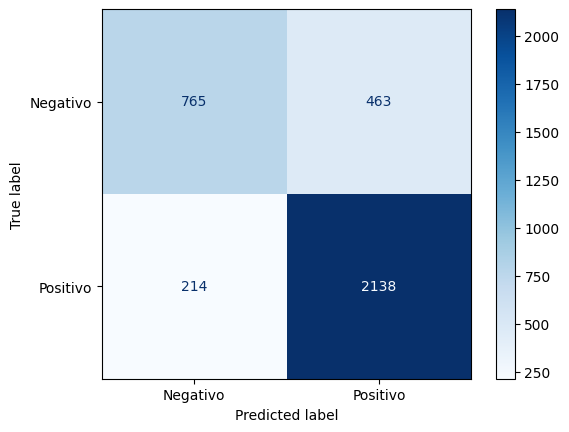

In [55]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calcular matriz de confusión
cm = confusion_matrix(y_prueba, regresion_logistica.predict(X_prueba))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negativo", "Positivo"])
disp.plot(cmap='Blues')

### GUARDANDO EL MODELO - USANDO COUNT VECTORIZER

In [56]:
import joblib

In [57]:
from joblib import dump, load
joblib.dump(regresion_logistica, 'modelo_entrenado_countvectorizer.pkl')

['modelo_entrenado_countvectorizer.pkl']

In [58]:
joblib.dump(vectorizador, 'countvectorizer.pkl')

['countvectorizer.pkl']

 ### TF-IDF (Term Frequency-Inverse Document Frequency)

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Inicializando el TfidfVectorizer
vectorizer = TfidfVectorizer()

# Aplicar TF-IDF a la columna 'tratamiento_3'
tfidf_matrix = vectorizer.fit_transform(df['tratamiento_3'])

In [60]:
# Convertir la matriz TF-IDF a un DataFrame para visualización
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=vectorizer.get_feature_names_out()
)
tfidf_df

,aa,aacept,aaj,aata,aavaz,aay,ab,abal,abd,abhi,...,zeroi,zeronoic,zerooveral,zfam,zindagi,zip,zl,zone,zthree,ztwo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14316,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14317,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14318,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
## Agregamos las nuevas caracteristicas generadas

tfidf_df['num_palabras'] = df['tratamiento_3'].apply(lambda x: len(x.split()))
tfidf_df['palabras_unicas'] = df['tratamiento_3'].apply(lambda x: len(set(x.split())))
tfidf_df['polaridad'] = df['tratamiento_3'].apply(lambda x: TextBlob(x).sentiment.polarity)
tfidf_df['subjetividad'] = df['tratamiento_3'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
tfidf_df['neg_words'] = df['tratamiento_3'].apply(neg)
tfidf_df['neu_words'] = df['tratamiento_3'].apply(neu)
tfidf_df['pos_words'] = df['tratamiento_3'].apply(pos)
tfidf_df['emotion'] = df['tratamiento_3'].apply(detect_emotion_chunks)
tfidf_df = pd.get_dummies(tfidf_df, columns=['emotion'])
tfidf_df = tfidf_df.astype(int)
tfidf_df

,aa,aacept,aaj,aata,aavaz,aay,ab,abal,abd,abhi,...,subjetividad,neg_words,neu_words,pos_words,emotion_anger,emotion_fear,emotion_joy,emotion_love,emotion_sadness,emotion_surprise
0,0,0,0,0,0,0,0,0,0,0,...,0,14,29,6,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,31,9,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,42,12,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,2,12,2,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,5,16,7,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14315,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
14316,0,0,0,0,0,0,0,0,0,0,...,0,0,4,0,0,0,1,0,0,0
14317,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
14318,0,0,0,0,0,0,0,0,0,0,...,0,0,4,5,0,0,1,0,0,0


### ENTRENANDO EL MODELO

In [63]:
### Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
from sklearn.model_selection import train_test_split

## standarización de matriz
from sklearn.preprocessing import StandardScaler
# scaler_tfidf = StandardScaler()
# tfidf_df_scaler = scaler_tfidf.fit_transform(tfidf_df)

X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(tfidf_df, df.sentimiento, random_state=4978)

### Crear y entrenar el modelo de regresión logística
from sklearn.linear_model import LogisticRegression
regresion_logistica_tfidf = LogisticRegression()
regresion_logistica_tfidf.fit(X_entrenamiento, y_entrenamiento)
exactitud_tfidf = regresion_logistica_tfidf.score(X_prueba, y_prueba)
print(exactitud_tfidf)

0.7687150837988826


* Observamos que con el count-vectorizer, obtuvimos mejores métricas.
* Decidimos utilizar el modelo entrenado con el Count-vectorizer.

## 4. EVALUANDO EL MODELO ENTRENADO EN DATOS REALES

### INSTALACIÓN DE LIBRERÍAS NECESARIAS

In [ ]:
%%capture
!pip install pandas numpy seaborn matplotlib scikit-learn nltk unidecode
!pip install nltk
!pip install emoji
!pip install vaderSentiment
!pip install textblob
!pip install num2words
!pip install transformers

### FUNCIONES Y LIBRERÍAS A CARGAR PREVIAMENTE

In [ ]:
import pandas as pd
import nltk
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import re
import string
import sklearn
import emoji
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
import math
from num2words import num2words
from sklearn.preprocessing import StandardScaler

import textblob
from textblob import TextBlob
import nltk
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

import warnings
warnings.filterwarnings('ignore')

## Buscamos reducir a su forma base las palabras
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

def neg(text):
  scores = analyzer.polarity_scores(text)
  return round(scores['neg']*len(text.split()))
def neu(text):
  scores = analyzer.polarity_scores(text)
  return round(scores['neu']*len(text.split()))
def pos(text):
  scores = analyzer.polarity_scores(text)
  return round(scores['pos']*len(text.split()))



from transformers import pipeline

# Cargar un modelo preentrenado de análisis de emociones
emotion_model = pipeline("text-classification", model="bhadresh-savani/distilbert-base-uncased-emotion")

# Función para dividir texto en fragmentos de tamaño máximo
def split_text_into_chunks(text, max_tokens=512):
    words = text.split()  # Dividimos el texto en palabras
    chunks = [" ".join(words[i:i + max_tokens]) for i in range(0, len(words), max_tokens)]
    return chunks

# Función para procesar texto en fragmentos
def detect_emotion_chunks(text):
    # Dividir en fragmentos
    chunks = split_text_into_chunks(text, max_tokens=512)

    # Procesar cada fragmento y obtener emociones
    emotions = [emotion_model(chunk, truncation=True)[0]['label'] for chunk in chunks]

    # Combinar emociones: la más frecuente (puedes usar otras reglas)
    dominant_emotion = max(set(emotions), key=emotions.count)
    return dominant_emotion

### CARGANDO LOS MODELOS PRE-ENTRENADOS

In [64]:
## Cargando el vectorizador
vectorizador_cargado = joblib.load('countvectorizer.pkl')
## cargando el modelo
modelo_cargado = joblib.load('modelo_entrenado_countvectorizer.pkl')

### 4.1 EN VARIAS FRASES A LA VEZ

In [92]:

frases = [
    {"texto": "Although the bass is decent, the rest of the performance is underwhelming.", "sentimiento": "Negative"},
    {"texto": "No doubt the bass is weak, and the overall experience was lacking", "sentimiento": "Negative"},
    {"texto": "The service was excellent, they attended me quickly and with great kindness.", "sentimiento": "Positive"},
    {"texto": "Nothing went as I expected, it was a complete waste of time.", "sentimiento": "Negative"},
    {"texto": "I loved the product, I would definitely recommend it to my friends.", "sentimiento": "Positive"}
]

## detectando con el modelo, primero clean(), luego stopwords, ultimo stemmer
frases_df = pd.DataFrame(frases)
frases_df_original = frases_df.copy()
frases_df

,texto,sentimiento
0,"Although the bass is decent, the rest of the p...",Negative
1,"No doubt the bass is weak, and the overall exp...",Negative
2,"The service was excellent, they attended me qu...",Positive
3,"Nothing went as I expected, it was a complete ...",Negative
4,"I loved the product, I would definitely recomm...",Positive


In [93]:
# Definir la función para procesar frases
def procesar_frases(frases_df, vectorizador, stemmer, neg, neu, pos, detect_emotion_chunks):

    # Limpieza inicial
    frases_df['texto_limpio'] = frases_df['texto'].apply(clean_text)

    # Eliminar stopwords
    frases_df['texto_limpio_2'] = frases_df['texto_limpio'].apply(
        lambda x: ' '.join([word for word in x.split() if word not in stopwords])
    )

    # Aplicar stemming
    frases_df['texto_limpio_3'] = frases_df['texto_limpio_2'].apply(
        lambda x: ' '.join([stemmer.stem(word) for word in x.split()])
    )

    # Transformar el texto limpio en matriz de características
    bolsa_frases = vectorizador.transform(frases_df['texto_limpio_3'])
    matriz_frases = pd.DataFrame.sparse.from_spmatrix(
        bolsa_frases,
        columns=vectorizador.get_feature_names_out()
    )

    # Calcular métricas adicionales
    matriz_frases['num_palabras'] = frases_df['texto_limpio_3'].apply(lambda x: len(x.split()))
    matriz_frases['palabras_unicas'] = frases_df['texto_limpio_3'].apply(lambda x: len(set(x.split())))
    matriz_frases['polaridad'] = frases_df['texto_limpio_3'].apply(lambda x: TextBlob(x).sentiment.polarity)
    matriz_frases['subjetividad'] = frases_df['texto_limpio_3'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
    matriz_frases['neg_words'] = frases_df['texto_limpio_3'].apply(neg)
    matriz_frases['neu_words'] = frases_df['texto_limpio_3'].apply(neu)
    matriz_frases['pos_words'] = frases_df['texto_limpio_3'].apply(pos)

    # Detectar emociones
    matriz_frases['emotion'] = frases_df['texto_limpio_3'].apply(detect_emotion_chunks)

    # Transformar emociones a dummies y convertir a entero
    matriz_frases = pd.get_dummies(matriz_frases, columns=['emotion'])
    matriz_frases = matriz_frases.astype(int)

    # Lista de emociones completas en el orden requerido
    emociones_completas = [
        "emotion_anger",
        "emotion_fear",
        "emotion_joy",
        "emotion_love",
        "emotion_sadness",
        "emotion_surprise"
    ]

    # Asegurar que todas las emociones estén en el DataFrame
    existing_columns = matriz_frases.columns
    existing_emotions = [emotion for emotion in emociones_completas if emotion in existing_columns]
    matriz_frases = matriz_frases.reindex(
        columns=matriz_frases.drop(columns=existing_emotions).columns.tolist() + emociones_completas,
        fill_value=0
    )

    # Inicializar el StandardScaler
    scaler = StandardScaler()

    # standarizando la matriz
    matriz_frases_scaler = scaler.fit_transform(matriz_frases)

    return matriz_frases_scaler

In [97]:
matriz_result = procesar_frases(frases_df, vectorizador_cargado, stemmer, neg, neu, pos, detect_emotion_chunks)

In [98]:
## predicción con el modelo_entrenado_countvectorizer.pkl
modelo_cargado.predict(matriz_result)

array(['positivo', 'negativo', 'positivo', 'positivo', 'positivo'],
      dtype=object)

In [99]:
frases_df_original['prediction'] = modelo_cargado.predict(matriz_result)
frases_df_original

,texto,sentimiento,prediction
0,"Although the bass is decent, the rest of the p...",Negative,positivo
1,"No doubt the bass is weak, and the overall exp...",Negative,negativo
2,"The service was excellent, they attended me qu...",Positive,positivo
3,"Nothing went as I expected, it was a complete ...",Negative,positivo
4,"I loved the product, I would definitely recomm...",Positive,positivo


### 4.2 EN UNA SOLA FRASE

In [106]:
def prediccion(texto, vectorizador, stemmer, neg, neu, pos, detect_emotion_chunks):
    texto_limpio = clean_text(texto)
    texto_limpio_2 = ' '.join([word for word in texto_limpio.split() if word not in (nltk.corpus.stopwords.words('english'))])
    texto_limpio_3 = ' '.join([stemmer.stem(word) for word in texto_limpio_2.split()])
    bolsa_frases = vectorizador_cargado.transform([texto_limpio_3])
    matriz_frases = pd.DataFrame.sparse.from_spmatrix(bolsa_frases, columns=vectorizador.get_feature_names_out())
    matriz_frases['num_palabras'] = len(texto_limpio_3.split())
    matriz_frases['palabras_unicas'] = len(set(texto_limpio_3.split()))
    matriz_frases['polaridad'] = TextBlob(texto_limpio_3).sentiment.polarity
    matriz_frases['subjetividad'] = TextBlob(texto_limpio_3).sentiment.subjectivity
    matriz_frases['neg_words'] = neg(texto_limpio_3)
    matriz_frases['neu_words'] = neu(texto_limpio_3)
    matriz_frases['pos_words'] = pos(texto_limpio_3)
    matriz_frases['emotion'] = detect_emotion_chunks(texto_limpio_3)
    matriz_frases = pd.get_dummies(matriz_frases, columns=['emotion'])
    matriz_frases = matriz_frases.astype(int)

    ## Asegurandome tener las mismas columnas que en el modelo cargado
    emociones_completas = [
        "emotion_anger",
        "emotion_fear",
        "emotion_joy",
        "emotion_love",
        "emotion_sadness",
        "emotion_surprise"
    ]
    existing_columns = matriz_frases.columns
    existing_emotions = [emotion for emotion in emociones_completas if emotion in existing_columns]

    matriz_frases = matriz_frases.reindex(columns=matriz_frases.drop(columns=existing_emotions).columns.tolist() + emociones_completas, fill_value=0)

    return modelo_cargado.predict(matriz_frases)

In [107]:
"""
    {"texto": "Although the bass is decent, the rest of the performance is underwhelming.", "sentimiento": "Negative"},
    {"texto": "No doubt the bass is weak, and the overall experience was lacking", "sentimiento": "Negative"},
    {"texto": "The service was excellent, they attended me quickly and with great kindness.", "sentimiento": "Positive"},
    {"texto": "Nothing went as I expected, it was a complete waste of time.", "sentimiento": "Negative"},
    {"texto": "I loved the product, I would definitely recommend it to my friends.", "sentimiento": "Positive"}
"""
texto = "No doubt the bass is weak, and the overall experience was lacking."
print(f'El texto ingresado, tiene alta probabilidad de ser un sentimiento: {prediccion(texto, vectorizador_cargado, stemmer, neg, neu, pos, detect_emotion_chunks)[0]}')

El texto ingresado, tiene alta probabilidad de ser un sentimiento: negativo


## 5. CONCLUSIONES

* Balance de emociones: Mejorar el equilibrio entre emociones negativas y positivas ayudaría al modelo a generalizar mejor y aumentar su precisión.

* Ampliación de características: Agregar más características enriquecería el modelo, haciéndolo más robusto y mejorando su capacidad de clasificación.

* Explorar redes neuronales: Probar con redes neuronales podría mejorar el rendimiento y la capacidad de generalización, ya que no se ha observado sobreajuste hasta ahora.

* Más datos: Ampliar la base de datos permitiría mejorar la precisión del modelo y manejar una mayor variedad emocional en los textos.

* Manejo de emoticones: Es importante tratar los emoticones de manera adecuada, ya que se eliminaron en la fase de preprocesamiento, lo que dejó algunas líneas vacías. Esto puede impactar la calidad de los datos y el rendimiento del modelo, por lo que debería considerarse su inclusión o un manejo adecuado.

* Tuning de hiperparámetros: Experimentar con diferentes configuraciones de hiperparámetros podría mejorar aún más el rendimiento y optimizar el modelo.
